<H1>Необходимо предсказать верхнюю границу заработной платы (salary_to) для вакансии</H1>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

import xlrd
from itertools import chain
pd.set_option('display.max_colwidth', None)

Считываем данные для обучения:

In [2]:
df = pd.read_csv('X_train.csv', parse_dates=['published_at', 'created_at'])

Считываем значения salary_to для данных для обучения и мерджим с предыдущей таблицей

In [3]:
df1 = pd.read_csv('y_train.csv')
df = df.set_index('id').join(df1.set_index('id'))

<H1>Исследование данных / Data exploration</H1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               23902 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   created_at                27934 non-null  datetime64[ns, UTC]
 8   employer_name             27934 non-null  object             
 9   description               27933 non-null  object             
 10  area_id                   27934 non-null  int64              
 11  area_name       

Можно увидеть, что есть пустые значения у <i>salary_from</i>. Есть пустые значения у <i>salary_gross</i>, который должен быть из описания bool, а импортировался как object. И ещё отсутствует одно значение в <i>description</i>.

In [5]:
pd.options.display.max_rows = 13
df.describe(include='O')

,name,salary_currency,salary_gross,employer_name,description,area_name
count,27934,27934,27786,27934,27933,27934
unique,16395,1,2,13318,23681,156
top,Менеджер по продажам,RUR,False,Пятёрочка,"<p><strong>Обязанности:</strong></p><ul><li>Обслуживание покупателей на кассе (наличный и безналичный расчет)</li><li>Выкладка товара в зале</li><li>Отслеживание сроков годности товара</li><li>Проверка наличия ценников</li><li>Консультация покупателей в зале</li></ul><p><strong>Требования:</strong></p><ul><li>Ответственность, дисциплинированность, внимательность</li></ul><p><strong>Условия:</strong></p><ul><li>График работы 5/2, 2/2, возможен неполный рабочий день, неполная рабочая неделя</li><li>Возможность подработки (работа по совместительству)</li><li>Социальные гарантии, оплата отпусков и больничных листов</li><li>Работа рядом с домом</li><li>Скидки в магазинах сети</li><li>Фирменная спецодежда</li><li>Возможность профессионального и карьерного роста, корпоративное обучение</li><li>Корпоративные мероприятия и конкурсы</li></ul>",Москва
freq,337,27934,18726,927,624,20512


<H1>Даты</H1>

Посмотрим корреляцию <i>published_at</i> и <i>created_at</i>.

In [6]:
#(df['published_at']==df['created_at']).value_counts()
df[['published_at', 'created_at']].corr().style.background_gradient(cmap='coolwarm')

,published_at,created_at
published_at,1.000000,1.000000
created_at,1.000000,1.000000


Эти столбцы полностью совпадают, один из них можно удалить.

In [7]:
df = df.drop(columns=['created_at'])

Разберемся с датами в <i>published_at</i>. Заменим даты на разницу между концом 2022 года (за который собирался dataset) и датой в <i>published_at</i>:

In [8]:
df['published_at_diff'] = df['published_at'].map(lambda x: datetime.timestamp(datetime(2023, 1, 1)) - x.timestamp())

Теперь столбец <i>published_at</i> можно удалить.

In [9]:
df = df.drop(columns=['published_at'])
#df = df.drop(columns=['published_at', 'published_at_diff'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               23902 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


<H1>Количественные / Quantitative</H1>

В salary_from есть пустые значения. Поместим туда среднее значение всего столбца:

In [11]:
#df = df.dropna(subset = ['salary_from'])
df.salary_from.fillna(df.salary_from.mean(), inplace = True) 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


Посмотрим на распределение всех числовых величин:

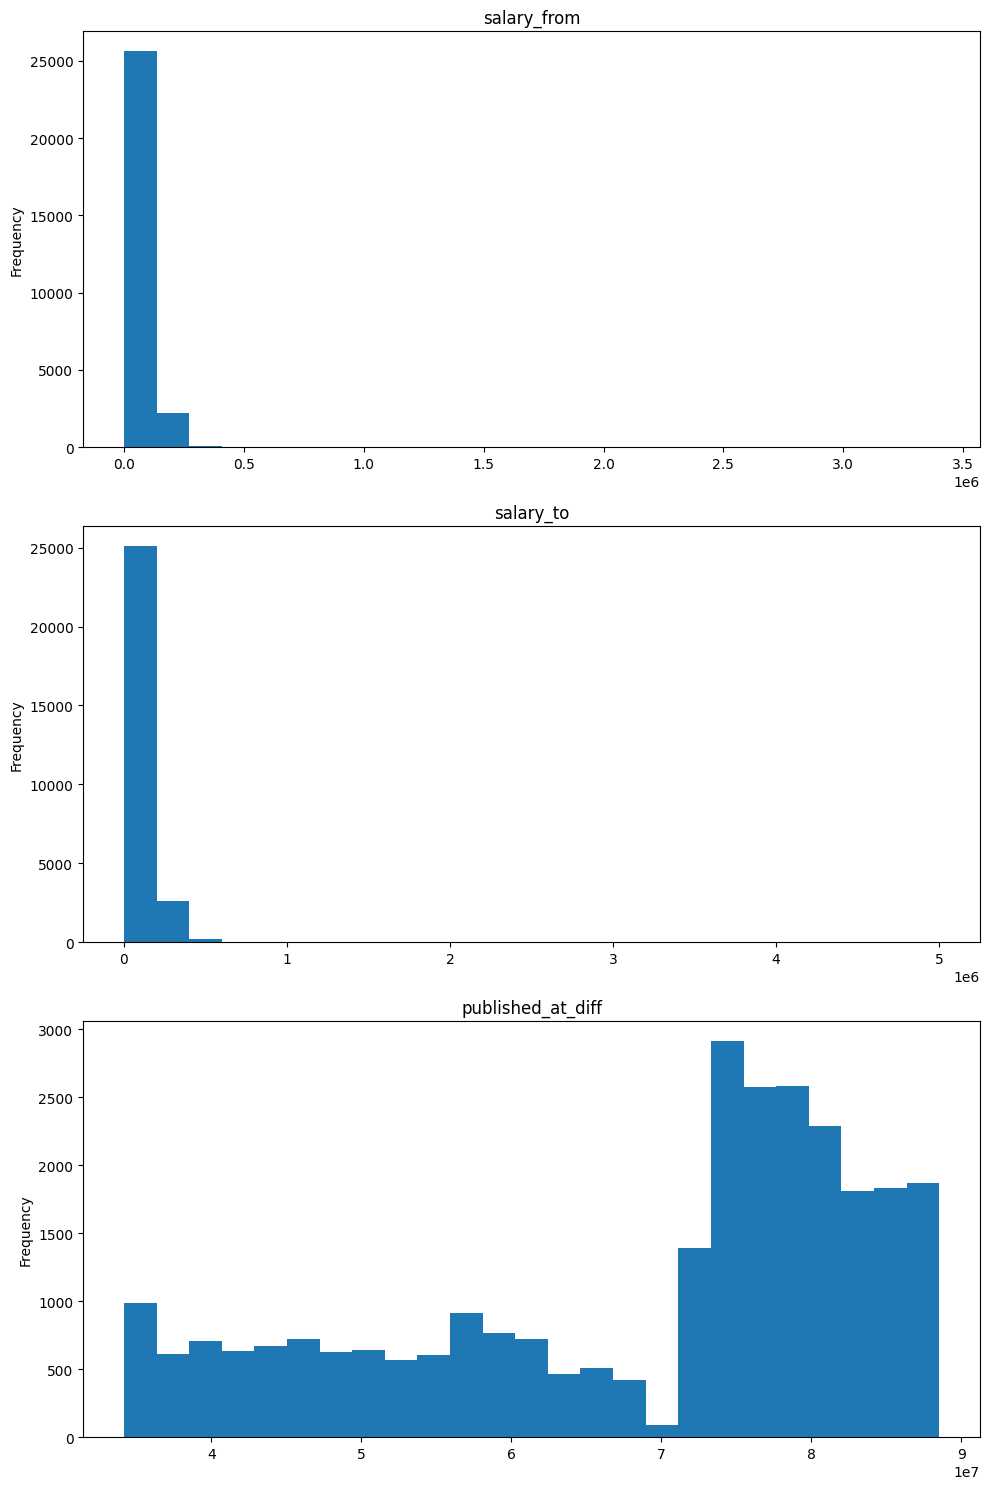

In [13]:
import matplotlib.pyplot as plt
df_numeric = df[['salary_from', 'salary_to', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric.columns):
    df_numeric[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

Нормализуем <i>publised_at_diff</i>:

In [14]:
df["published_at_diff"] = df["published_at_diff"] / 1e7

In [15]:
df['published_at_diff'] = df['published_at_diff'].map(lambda x: "Recent" if x < 5 else "Middle" if x >= 5 and x < 7 else "Old")
#df['published_at_diff1'] = df['published_at_diff'].map(lambda x: "Recent" if x <= 1.0 else "Old")

<H1>Категориальные / Category</H1>

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  object 
dtypes: bool(2), float64(2), int64(1), object(7)
memory usage: 3.4+ MB


<H2>salary_gross</H2>

Для <i>salary_gross</i> нужно заполнить пропуски False и преобразовать из типа object в тип bool: 

In [17]:
df.salary_gross.fillna(False, inplace = True) 
df['salary_gross'] = df['salary_gross'].astype(bool)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27934 non-null  bool   
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  object 
dtypes: bool(3), float64(2), int64(1), object(6)
memory usage: 3.2+ MB


<H2>salary_currency</H2>

Посмотрим, сколько уникальных значений есть в <i>salary_currency</i>.

In [19]:
df['salary_currency'].value_counts()

salary_currency
RUR    27934
Name: count, dtype: int64

У всех строк одна и та же валюта, этот столбец можно удалить.

In [20]:
df = df.drop(columns=['salary_currency'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27933 non-null  object 
 7   area_id                   27934 non-null  int64  
 8   area_name                 27934 non-null  object 
 9   salary_to                 27934 non-null  float64
 10  published_at_diff         27934 non-null  object 
dtypes: bool(3), float64(2), int64(1), object(5)
memory usage: 3.0+ MB


<H2>area_name и area_id</H2>

Разберемся с <i>area_id</i> и <i>area_name</i>.

In [22]:
map_id_to_name = {}
for idx in df.index:
    if df['area_id'][idx] in map_id_to_name:
        map_id_to_name[df['area_id'][idx]].add((df['area_name'][idx], ))
    else:
        map_id_to_name[df['area_id'][idx]] = set(((df['area_name'][idx], ), ))
map_id_to_name

{1: {('Москва',)},
 2: {('Санкт-Петербург',)},
 72: {('Пермь',)},
 4: {('Новосибирск',)},
 78: {('Самара',)},
 26: {('Воронеж',)},
 35: {('Иркутск',)},
 3: {('Екатеринбург',)},
 77: {('Рязань',)},
 24: {('Волгоград',)},
 76: {('Ростов-на-Дону',)},
 54: {('Красноярск',)},
 53: {('Краснодар',)},
 66: {('Нижний Новгород',)},
 96: {('Ижевск',)},
 247: {('Дзержинск (Нижегородская область)',)},
 41: {('Калининград',)},
 90: {('Томск',)},
 98: {('Ульяновск',)},
 130: {('Севастополь',)},
 68: {('Омск',)},
 43: {('Калуга',)},
 99: {('Уфа',)},
 22: {('Владивосток',)},
 49: {('Киров (Кировская область)',)},
 88: {('Казань',)},
 32: {('Иваново (Ивановская область)',)},
 1002: {('Минск',)},
 44: {('Петропавловск-Камчатский',)},
 112: {('Ярославль',)},
 160: {('Алматы',)},
 104: {('Челябинск',)},
 2734: {('Иннополис',)},
 92: {('Тула',)},
 71: {('Пенза',)},
 2088: {('Зеленоград',)},
 2059: {('Павловский Посад',)},
 159: {('Нур-Султан',)},
 83: {('Смоленск',)},
 79: {('Саратов',)},
 89: {('Тверь',)},

Удалим <i>area_id</i>, и посмотрим на то, сколько раз встречается тот или иной город.

In [23]:
df = df.drop(columns=['area_id'])

In [24]:
df['area_name'].value_counts()

area_name
Москва                         20512
Санкт-Петербург                 5393
Новосибирск                      201
Краснодар                        178
Екатеринбург                     158
                               ...  
Каменск-Шахтинский                 1
Стерлитамак                        1
Турция                             1
Донецк (Ростовская область)        1
Курган                             1
Name: count, Length: 156, dtype: int64

Начнем с area_name

Выделим несколько часто встречающихся городов, остальные заменим Other:

In [25]:
df.loc[df["area_name"].value_counts()[df["area_name"]].values < 2, "area_name"] = "Other"
df['area_name'].value_counts()

area_name
Москва             20512
Санкт-Петербург     5393
Новосибирск          201
Краснодар            178
Екатеринбург         158
                   ...  
Польша                 2
Псков                  2
Сургут                 2
Ковров                 2
Сергиев Посад          2
Name: count, Length: 93, dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27933 non-null  object 
 7   area_name                 27934 non-null  object 
 8   salary_to                 27934 non-null  float64
 9   published_at_diff         27934 non-null  object 
dtypes: bool(3), float64(2), object(5)
memory usage: 2.8+ MB


<H2>description</H2>

В колонке <i>description</i> есть много информации, написанной в виде HTML страницы. Есть вероятность, что там есть упоминание з/п в формате "<число> руб." или "<число> руб./час" или "<число> тыс. руб.". Попробуем их выцепить. Сначала удалим HTML теги из всех записей

In [27]:
import re
df['description'] = pd.Series(df['description'],dtype=pd.StringDtype())
df.description = df.description.apply(lambda x: str(x).lower())
df.description = df.description.apply(lambda x: re.sub(r'</?[A-Za-z0-9]+ ?/?>', ' ', str(x)))

Определим функцию, которая будет извлекать из строки description максимальную упомянотую зарплату. Если таковой нет, сделаем её равной 0. Также сделаем равной 0 зарплаты, которые получились меньше 1000. Такое могло произойти, если извлеченная зарплата была не той по смыслу, или была какая-то другая цена.

In [28]:
def manage_desc(string):
    #print(string)
    pattern = r'[0-9][0-9.,тыс ]+[0-9 ]руб.?\/?[а-яА-Я ]*([0-9 ]+час)?(час)?(мес)?(день)?'
    max_salary = -1
    for match_raw in re.finditer(pattern, string):
        number = ''
        match = match_raw.group()
        #print(match)
        first_numeric_found = False
        for ch in match:
            if ch.isnumeric():
                number += ch
                first_numeric_found = True
            elif ch == ' ' or ch == ',' or ch == '.':
                pass
            else:
                if first_numeric_found:
                    break
        salary = int(number)
        if 'сут' in match or 'день' in match:
            salary *= 20
        elif 'час' in match:
            salary *= 160

        if 'тыс' in match or 'т.' in match:
            salary *= 1000
        
        if max_salary == -1 or salary > max_salary:
            max_salary = salary
    
    if (max_salary < 1000):
        return pd.NA
    else:
        return max_salary

#manage_desc(df['description'][23187])

Теперь преобразуем все description

In [29]:
df.description = df.description.map(manage_desc)
df.description.value_counts()

description
40000         354
50000         331
60000         312
30000         269
100000        256
             ... 
1000000000      1
145000          1
648000          1
34900           1
25500           1
Name: count, Length: 354, dtype: int64

Заполним пустые значения значениями из <i>salary_from</i>

In [30]:
df.description.fillna(df['salary_from'], inplace = True) 
#df = df.drop(columns=['description'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27934 non-null  float64
 7   area_name                 27934 non-null  object 
 8   salary_to                 27934 non-null  float64
 9   published_at_diff         27934 non-null  object 
dtypes: bool(3), float64(3), object(4)
memory usage: 2.8+ MB


<H2>employer_name</H2>

Далее посмотрим на employer_name

In [32]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    927
Пятерочка                    669
Перекресток                  324
Билайн                       261
JCat.ru                       70
                            ... 
Торговая группа ПТК            1
LTG Consulting                 1
ExMail                         1
Албаков Руслан Борисович       1
Балтик Граунд Сервисес РУ      1
Name: count, Length: 13318, dtype: int64

Во первых, можно увидеть два разных написания "Пятерочка", возможно есть другие названия, которые отличаются в одном символе. Посмотрим на верхние 3 значения.

In [33]:
def near_equal(string, pattern):
    string1 = string.strip()
    string2 = pattern.strip()
    max_len = max(len(string1), len(string2))
    min_len = min(len(string1), len(string2))
    score = 0
    for i in range(0, min_len):
        if (string1[i] == string2[i]):
            score += 1

    return score / max_len

In [34]:
df.employer_name = df.employer_name.apply(lambda x: x.lower())

In [36]:
import re

map_empl_name_to_count = {}
for idx in df.index:
    split = re.split('[^a-zA-Zа-яА-ЯёЁ]+', df['employer_name'][idx])
    split = list(filter(None, split))
    for entry in split:
        if len(entry) > 2:
            if entry in map_empl_name_to_count:
                map_empl_name_to_count[entry] = map_empl_name_to_count[entry] + 1
            else:
                for key in map_empl_name_to_count:
                    if near_equal(key, entry) >= 0.75:
                        map_empl_name_to_count[key] = map_empl_name_to_count[key] + 1
                        break;
                else:
                    map_empl_name_to_count[entry] = 1

In [ ]:
map_empl_name_to_count

In [39]:
map_empl_name_to_count1 = {k: v for k, v in map_empl_name_to_count.items() if v >= 200}
sorted_empl_names_to_count = sorted(map_empl_name_to_count1.items(), key=lambda x:x[1], reverse=True)

In [40]:
sorted_empl_names_to_count

[('пятёрочка', 1596),
 ('группа', 914),
 ('компаний', 860),
 ('центр', 611),
 ('group', 410),
 ('сеть', 398),
 ('перекресток', 324),
 ('школа', 312),
 ('агентство', 306),
 ('билайн', 269),
 ('москвы', 265),
 ('сервис', 238),
 ('россия', 231),
 ('технологии', 228)]

In [41]:
array_false = [False] * len(df)
array_true = [True] * len(df)

for key, val in sorted_empl_names_to_count:
    composite = 'employer_name_' + key
    df[composite] = array_false
df['employer_name_other'] = array_true

df

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,salary_to,published_at_diff,...,employer_name_сеть,employer_name_перекресток,employer_name_школа,employer_name_агентство,employer_name_билайн,employer_name_москвы,employer_name_сервис,employer_name_россия,employer_name_технологии,employer_name_other
id,,,,,,,,,,,,,,,,,,,,,
29083,Менеджер по продажам (брокер) элитной городской недвижимости,False,False,64179.458874,False,villagio estate,64179.458874,Москва,200000.0,Old,...,False,False,False,False,False,False,False,False,False,True
26052,Product marketing manager / Продуктовый маркетолог,False,False,120000.000000,False,cityads media,120000.000000,Москва,170000.0,Old,...,False,False,False,False,False,False,False,False,False,True
24055,Программист Python (Middle),False,False,64179.458874,False,лендсбэй,64179.458874,Москва,120000.0,Old,...,False,False,False,False,False,False,False,False,False,True
4408,"Продавец-кассир (Москва, Вернадского, 93)",False,False,33500.000000,True,пятёрочка,33500.000000,Москва,38000.0,Old,...,False,False,False,False,False,False,False,False,False,True
16856,Дизайнер-визуализатор,False,True,30000.000000,True,моллдекор рус,30000.000000,Москва,35000.0,Recent,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,Директор департамента по административной и кадровой работе,False,False,120000.000000,False,балтик граунд сервисес ру,120000.000000,Москва,150000.0,Recent,...,False,False,False,False,False,False,False,False,False,True
6265,"Продавец-кассир (г Москва, ул Смольная, д 67 к 2)",False,False,33500.000000,True,пятёрочка,33500.000000,Москва,38000.0,Old,...,False,False,False,False,False,False,False,False,False,True
11284,Младший аналитик данных,False,False,50000.000000,False,баскаков дмитрий владимирович,50000.000000,Москва,70000.0,Middle,...,False,False,False,False,False,False,False,False,False,True


In [42]:
for idx in df.index:
    split = re.split('[^a-zA-Zа-яА-ЯёЁ]+', df['employer_name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_empl_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'employer_name_' + key
                df[composite][idx] = True
                df['employer_name_other'][idx] = False

df

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,salary_to,published_at_diff,...,employer_name_сеть,employer_name_перекресток,employer_name_школа,employer_name_агентство,employer_name_билайн,employer_name_москвы,employer_name_сервис,employer_name_россия,employer_name_технологии,employer_name_other
id,,,,,,,,,,,,,,,,,,,,,
29083,Менеджер по продажам (брокер) элитной городской недвижимости,False,False,64179.458874,False,villagio estate,64179.458874,Москва,200000.0,Old,...,False,False,False,False,False,False,False,False,False,True
26052,Product marketing manager / Продуктовый маркетолог,False,False,120000.000000,False,cityads media,120000.000000,Москва,170000.0,Old,...,False,False,False,False,False,False,False,False,False,True
24055,Программист Python (Middle),False,False,64179.458874,False,лендсбэй,64179.458874,Москва,120000.0,Old,...,False,False,False,False,False,False,False,False,False,True
4408,"Продавец-кассир (Москва, Вернадского, 93)",False,False,33500.000000,True,пятёрочка,33500.000000,Москва,38000.0,Old,...,False,False,False,False,False,False,False,False,False,False
16856,Дизайнер-визуализатор,False,True,30000.000000,True,моллдекор рус,30000.000000,Москва,35000.0,Recent,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,Директор департамента по административной и кадровой работе,False,False,120000.000000,False,балтик граунд сервисес ру,120000.000000,Москва,150000.0,Recent,...,False,False,False,False,False,False,True,False,False,False
6265,"Продавец-кассир (г Москва, ул Смольная, д 67 к 2)",False,False,33500.000000,True,пятёрочка,33500.000000,Москва,38000.0,Old,...,False,False,False,False,False,False,False,False,False,False
11284,Младший аналитик данных,False,False,50000.000000,False,баскаков дмитрий владимирович,50000.000000,Москва,70000.0,Middle,...,False,False,False,False,False,False,False,False,False,True


In [43]:
df = df.drop(columns=['employer_name'])

In [ ]:
df.employer_name = df.employer_name.apply(lambda x: "пятёрочка" if near_equal(x, "пятёрочка") >= 0.85 else x)

In [ ]:
df.employer_name = df.employer_name.apply(lambda x: "перекресток" if near_equal(x, "перекресток") >= 0.8 else x)

In [ ]:
df.employer_name = df.employer_name.apply(lambda x: "билайн" if near_equal(x, "билайн") >= 0.8 else x)

В списке <i>employer_name</i> есть ИП, написанные как ФИО. Заменим их всех на категорию "personname"

In [ ]:
df.employer_name = df.employer_name.apply(lambda x: "personname" if x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') else x) #or x.startswith('ип') or '(ип ' in x)
df['employer_name'].value_counts()

In [ ]:
df['employer_name'].value_counts()

Оставим верхние 4 значения, а другие заменим на other:

In [ ]:
df.loc[df["employer_name"].value_counts()[df["employer_name"]].values < 200, "employer_name"] = "other"
df['employer_name'].value_counts()

<H2>name</H2>

Теперь рассмотрим последний столбец: <i>name</i>

In [44]:
df['name'].value_counts()

name
Менеджер по продажам                                   337
Менеджер по работе с клиентами                         201
Юрист                                                  162
Помощник юриста                                        149
Аналитик                                               145
                                                      ... 
Бизнес-аналитик(Внедренец/ Ведущий бизнес-аналитик)      1
Руководитель департамента коммерческой недвижимости      1
Логист- оператор / Грузчик (ТРК Европолис)               1
User Acquisition Manager                                 1
Копирайтер / контент менеджер                            1
Name: count, Length: 16395, dtype: int64

Сначала преобразуем всё к нижнему регистру:

In [45]:
df.name = df.name.apply(lambda x: x.lower())
df.name = df.name.apply(lambda x: x.strip())
df.name.value_counts()

name
менеджер по продажам                                   340
менеджер по работе с клиентами                         202
юрист                                                  162
уборщица/уборщик                                       150
помощник юриста                                        149
                                                      ... 
руководитель департамента коммерческой недвижимости      1
логист- оператор / грузчик (трк европолис)               1
user acquisition manager                                 1
конструктор - технолог корпусной мебели                  1
копирайтер / контент менеджер                            1
Name: count, Length: 16089, dtype: int64

Можно увидеть перечисления через /, либо доп. указания в скобках. 

In [46]:
import re

map_name_to_count = {}
for idx in df.index:
    split = re.split('[^a-zA-Zа-яА-ЯёЁ]+', df['name'][idx])
    split = list(filter(None, split))
    for entry in split:
        if len(entry) > 2:
            if entry in map_name_to_count:
                map_name_to_count[entry] = map_name_to_count[entry] + 1
            else:
                for key in map_name_to_count:
                    if near_equal(key, entry) >= 0.75:
                        map_name_to_count[key] = map_name_to_count[key] + 1
                        break;
                else:
                    map_name_to_count[entry] = 1
#map_name_to_count

In [47]:
map_name_to_count1 = {k: v for k, v in map_name_to_count.items() if v >= 1000}
sorted_names_to_count = sorted(map_name_to_count1.items(), key=lambda x:x[1], reverse=True)
#sorted_names_to_count

In [48]:
array_false = [False] * len(df)
array_true = [True] * len(df)

for key, val in sorted_names_to_count:
    composite = 'name_' + key
    df[composite] = array_false
df['name_other'] = array_true

df

,name,has_test,response_letter_required,salary_from,salary_gross,description,area_name,salary_to,published_at_diff,employer_name_пятёрочка,...,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_помощник,name_отдел,name_other
id,,,,,,,,,,,,,,,,,,,,,
29083,менеджер по продажам (брокер) элитной городской недвижимости,False,False,64179.458874,False,64179.458874,Москва,200000.0,Old,False,...,False,False,False,False,False,False,False,False,False,True
26052,product marketing manager / продуктовый маркетолог,False,False,120000.000000,False,120000.000000,Москва,170000.0,Old,False,...,False,False,False,False,False,False,False,False,False,True
24055,программист python (middle),False,False,64179.458874,False,64179.458874,Москва,120000.0,Old,False,...,False,False,False,False,False,False,False,False,False,True
4408,"продавец-кассир (москва, вернадского, 93)",False,False,33500.000000,True,33500.000000,Москва,38000.0,Old,True,...,False,False,False,False,False,False,False,False,False,True
16856,дизайнер-визуализатор,False,True,30000.000000,True,30000.000000,Москва,35000.0,Recent,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,директор департамента по административной и кадровой работе,False,False,120000.000000,False,120000.000000,Москва,150000.0,Recent,False,...,False,False,False,False,False,False,False,False,False,True
6265,"продавец-кассир (г москва, ул смольная, д 67 к 2)",False,False,33500.000000,True,33500.000000,Москва,38000.0,Old,True,...,False,False,False,False,False,False,False,False,False,True
11284,младший аналитик данных,False,False,50000.000000,False,50000.000000,Москва,70000.0,Middle,False,...,False,False,False,False,False,False,False,False,False,True


In [49]:
for idx in df.index:
    split = re.split('[^a-zA-Zа-яА-ЯёЁ]+', df['name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'name_' + key
                df[composite][idx] = True
                df['name_other'][idx] = False

df

,name,has_test,response_letter_required,salary_from,salary_gross,description,area_name,salary_to,published_at_diff,employer_name_пятёрочка,...,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_помощник,name_отдел,name_other
id,,,,,,,,,,,,,,,,,,,,,
29083,менеджер по продажам (брокер) элитной городской недвижимости,False,False,64179.458874,False,64179.458874,Москва,200000.0,Old,False,...,False,False,False,False,False,False,False,False,False,False
26052,product marketing manager / продуктовый маркетолог,False,False,120000.000000,False,120000.000000,Москва,170000.0,Old,False,...,False,False,False,False,False,False,False,False,False,True
24055,программист python (middle),False,False,64179.458874,False,64179.458874,Москва,120000.0,Old,False,...,False,False,False,False,False,True,False,False,False,False
4408,"продавец-кассир (москва, вернадского, 93)",False,False,33500.000000,True,33500.000000,Москва,38000.0,Old,True,...,False,False,False,False,False,False,False,False,False,False
16856,дизайнер-визуализатор,False,True,30000.000000,True,30000.000000,Москва,35000.0,Recent,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,директор департамента по административной и кадровой работе,False,False,120000.000000,False,120000.000000,Москва,150000.0,Recent,False,...,False,False,False,True,False,False,False,False,False,False
6265,"продавец-кассир (г москва, ул смольная, д 67 к 2)",False,False,33500.000000,True,33500.000000,Москва,38000.0,Old,True,...,False,False,False,False,False,False,False,False,False,False
11284,младший аналитик данных,False,False,50000.000000,False,50000.000000,Москва,70000.0,Middle,False,...,False,False,False,False,False,False,True,False,False,False


In [50]:
df = df.drop(columns=['name'])

<H1>One-Hotting</H1>

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   has_test                   27934 non-null  bool   
 1   response_letter_required   27934 non-null  bool   
 2   salary_from                27934 non-null  float64
 3   salary_gross               27934 non-null  bool   
 4   description                27934 non-null  float64
 5   area_name                  27934 non-null  object 
 6   salary_to                  27934 non-null  float64
 7   published_at_diff          27934 non-null  object 
 8   employer_name_пятёрочка    27934 non-null  bool   
 9   employer_name_группа       27934 non-null  bool   
 10  employer_name_компаний     27934 non-null  bool   
 11  employer_name_центр        27934 non-null  bool   
 12  employer_name_group        27934 non-null  bool   
 13  employer_name_сеть         27934 non-null  bool

Сделаем one-hotting категориальных фич:

In [52]:
df_one_hoted = df.copy()

#ONE_HOT_COL = ['published_at_diff']
ONE_HOT_COL = ['area_name', 'published_at_diff'] #'name', , 'employer_name', 

temp = pd.get_dummies(df_one_hoted[ONE_HOT_COL], prefix=ONE_HOT_COL, dtype=bool)

df_one_hoted = pd.concat([temp, df], axis=1)

df_one_hoted.head()

,area_name_Other,area_name_Алматы,area_name_Архангельск,area_name_Астрахань,area_name_Балашиха,area_name_Барнаул,area_name_Белгород,area_name_Бишкек,area_name_Брянск,area_name_Великий Новгород,...,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_помощник,name_отдел,name_other
id,,,,,,,,,,,,,,,,,,,,,
29083,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26052,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
24055,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4408,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16856,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Удалим столбцы:

In [53]:
df_one_hoted = df_one_hoted.drop(columns=['area_name', 'published_at_diff'])#, 'name', 'employer_name',  ])
#df_one_hoted = df_one_hoted.drop(columns=['published_at_diff'])

In [54]:
df_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Columns: 134 entries, area_name_Other to name_other
dtypes: bool(131), float64(3)
memory usage: 5.4 MB


In [55]:
df = df_one_hoted

<H1>Корреляция</H1>

In [56]:
df.corr().style.background_gradient(cmap='coolwarm')

<H1>Создание модели</H1>

In [57]:
from sklearn.model_selection import train_test_split


#df_sampled = df.sample(20_000)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='salary_to'), df.salary_to, test_size=0.2)

In [58]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [59]:
%%time
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

y_pred_train = model_LR.predict(X_train)
y_pred_test = model_LR.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 31.894810925570873, SMAPE test: 32.3724886920067
CPU times: user 2.77 s, sys: 10.9 s, total: 13.7 s
Wall time: 2.83 s


In [60]:
model_SGR = SGDRegressor() # epsilon_insensitive, huber, squared_loss
model_SGR.fit(X_train, y_train)

y_pred_train = model_SGR.predict(X_train)
y_pred_test = model_SGR.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 200.0, SMAPE test: 200.0


In [61]:
%%time
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


xg_model = XGBRegressor(n_estimators  = 10)
xg_model.fit(X_train, y_train)

y_pred_train = xg_model.predict(X_train)
y_pred_test = xg_model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 28.718642789485845, SMAPE test: 29.0607264111356
CPU times: user 6.96 s, sys: 435 ms, total: 7.39 s
Wall time: 3.18 s


In [62]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


model = RandomForestRegressor(n_estimators=100)#criterion='friedman_mse')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 18.076113719315725, SMAPE test: 25.24147573292587
CPU times: user 24.7 s, sys: 196 ms, total: 24.9 s
Wall time: 26.6 s


In [63]:
model.score(X_test, y_test)

0.5119256363531659

In [64]:
importances = dict(zip(model.feature_names_in_, model.feature_importances_))
importances = {k: v for k,v in sorted(importances.items(), key=lambda x: x[1], reverse=True)}

In [65]:
importances

{'salary_from': 0.5845016061149871,
 'description': 0.12035064414780602,
 'published_at_diff_Old': 0.03466708374998466,
 'employer_name_компаний': 0.024109967893893886,
 'salary_gross': 0.02130481588262528,
 'name_продажам': 0.020456584925149186,
 'name_продавец': 0.019711339483928517,
 'name_other': 0.012615040783152766,
 'response_letter_required': 0.012101674773454356,
 'has_test': 0.011451886871226793,
 'name_developer': 0.010604582537553222,
 'name_разработчик': 0.010425621855581886,
 'name_специалист': 0.010012570596474295,
 'employer_name_other': 0.0099886503678953,
 'area_name_Москва': 0.009820332901078276,
 'name_менеджер': 0.009664967465029256,
 'area_name_Санкт-Петербург': 0.00879848510136041,
 'published_at_diff_Recent': 0.0072770809357619445,
 'name_отдел': 0.005203797873063626,
 'name_помощник': 0.0049325022635196905,
 'published_at_diff_Middle': 0.0045546499354163945,
 'name_работе': 0.004491696393984754,
 'employer_name_москвы': 0.004285445077520595,
 'name_инженер': 0.

<H1>Тестовая дата</H1>

Загрузим тестовую таблицу:

In [66]:
df_test = pd.read_csv('X_test.csv', parse_dates=['published_at', 'created_at'])

Сразу уберем столбцы salary_currency (одно и то же значение), created_at (совпадает с published_at) и area_id (аналогично area_name):

In [67]:
df_test = df_test.drop(columns=['salary_currency', 'created_at', 'area_id'])

In [68]:
df_test = df_test.set_index('id')

Заполняем salary_gross, если есть пропуски:

In [69]:
df_test.salary_gross.fillna(False, inplace = True) 
df_test['salary_gross'] = df_test['salary_gross'].astype(bool)

Заполняем пустые salary_from средним:

In [70]:
df_test.salary_from.fillna(df_test.salary_from.mean(), inplace = True) 

Преобразуем published_at, как и с обучаемым dataset:

In [71]:
df_test['published_at_diff'] = df_test['published_at'].map(lambda x: datetime.timestamp(datetime(2023, 1, 1)) - x.timestamp())

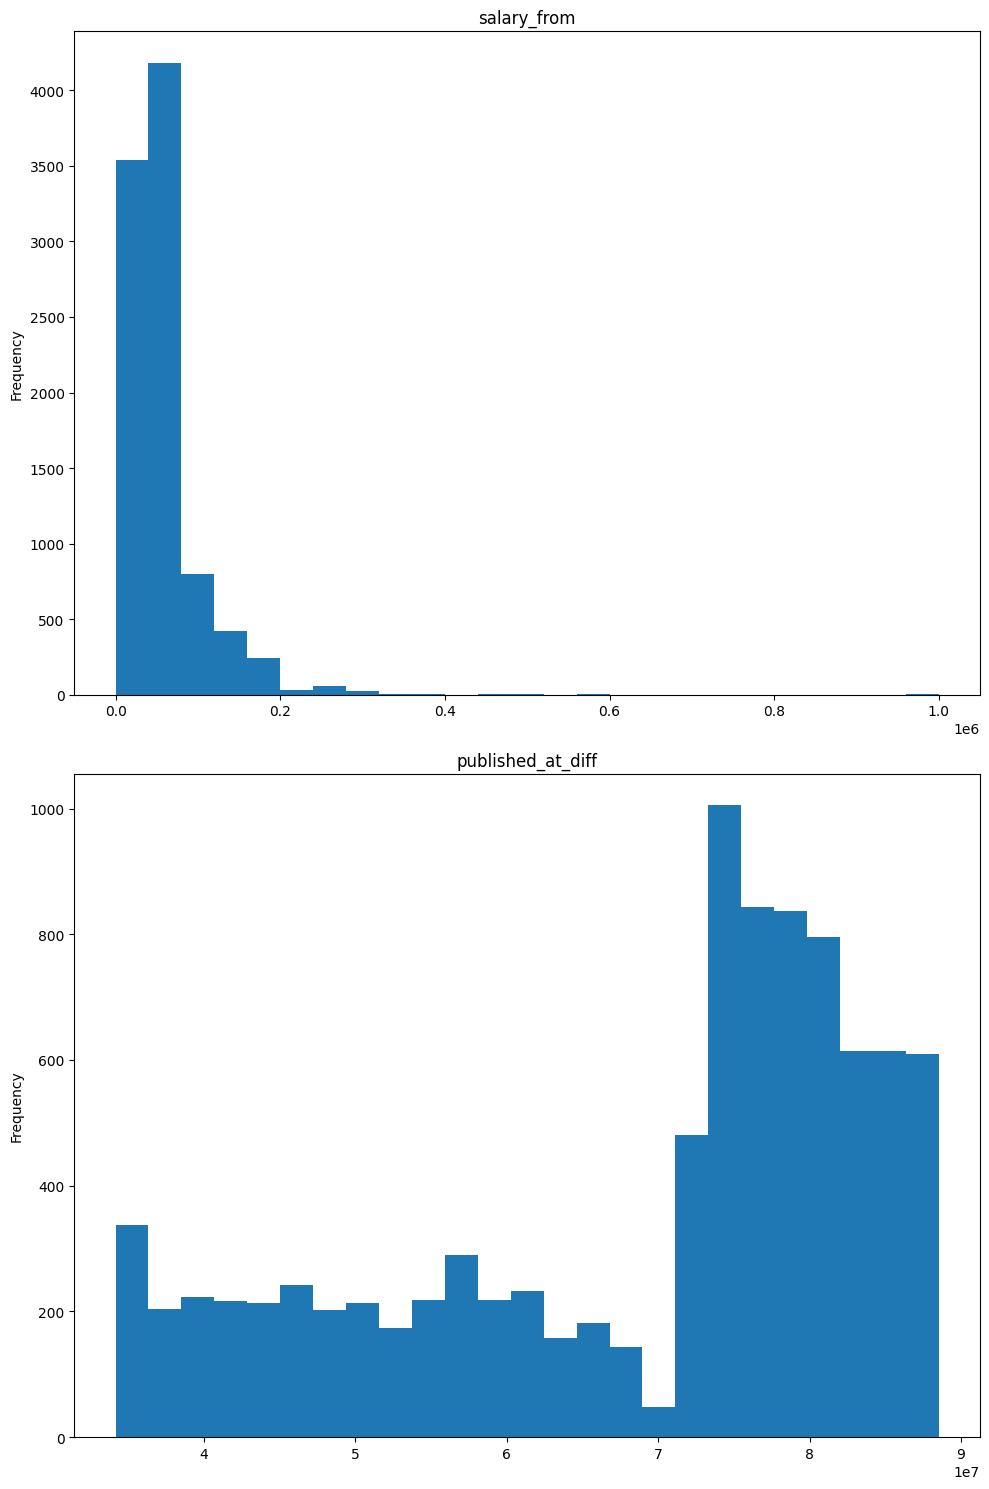

In [75]:
import matplotlib.pyplot as plt
df_numeric1 = df_test[['salary_from', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric1.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric1.columns):
    df_numeric1[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [76]:
df_test["published_at_diff"] = df_test["published_at_diff"] / 1e7
df_test['published_at_diff'] = df_test['published_at_diff'].map(lambda x: "Recent" if x < 5 else "Middle" if x >= 5 and x < 7 else "Old")
df_test = df_test.drop(columns=['published_at'])

Преобразуем description:

In [77]:
df_test.description = df_test.description.map(manage_desc)
df_test.description.value_counts()

description
40000         126
60000         107
50000          91
30000          85
100000         81
             ... 
1375            1
92400           1
1500030000      1
52800           1
1600000         1
Name: count, Length: 211, dtype: int64

In [78]:
df_test.description.fillna(df_test.salary_from, inplace = True) 

Для area_name, оставим название, если в обучаемом dataset есть столбец, иначе заменяем на Other:

In [79]:
df_test['area_name'] = df_test['area_name'].map(lambda x: x if ('area_name_' + x) in df.columns else "Other")

In [80]:
df_test.area_name.value_counts()

area_name
Москва                       6754
Санкт-Петербург              1877
Новосибирск                    71
Казань                         54
Краснодар                      52
                             ... 
Киров (Кировская область)       1
Балашиха                        1
Магнитогорск                    1
Химки                           1
США                             1
Name: count, Length: 77, dtype: int64

Преобразуем employer_name к нижнему регистру, и сделаем те же преобразования, что и в обучаемом dataset:

In [81]:
df_test.employer_name = df_test.employer_name.apply(lambda x: x.lower())

In [83]:
array_false1 = [False] * len(df_test)
array_true1 = [True] * len(df_test)

for key, val in sorted_empl_names_to_count:
    composite = 'employer_name_' + key
    df_test[composite] = array_false1
df_test['employer_name_other'] = array_true1

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,published_at_diff,employer_name_пятёрочка,...,employer_name_сеть,employer_name_перекресток,employer_name_школа,employer_name_агентство,employer_name_билайн,employer_name_москвы,employer_name_сервис,employer_name_россия,employer_name_технологии,employer_name_other
id,,,,,,,,,,,,,,,,,,,,,
20978,техник по инструменту / специалист по инструменту (ауди центр таганка),False,False,35000.000000,False,автоспеццентр,35000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
3102,диспетчер по заказам,False,False,20000.000000,False,автовыкуп,20000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
14731,frontend developer в focus calendar,False,False,200000.000000,False,focus calendar,200000.000000,Москва,Recent,False,...,False,False,False,False,False,False,False,False,False,True
16113,системный аналитик,False,False,150000.000000,False,intech,150000.000000,Москва,Recent,False,...,False,False,False,False,False,False,False,False,False,True
8410,front-end разработчик (javascript),False,False,80000.000000,False,кравцов и.н.,80000.000000,Кемерово,Middle,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,обходчик объекта,False,False,40000.000000,False,монтажспецстрой,40000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
34298,it рекрутер (удаленно),False,False,40000.000000,False,soft personal,40000.000000,Новосибирск,Middle,False,...,False,False,False,False,False,False,False,False,False,True
33921,"старший продавец-кассир (москва, бульвар яна райниса, 26к1)",False,False,35000.000000,True,пятёрочка,35000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True


In [85]:
for idx in df_test.index:
    split = re.split('[^a-zA-Zа-яА-ЯёЁ]+', df_test['employer_name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_empl_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'employer_name_' + key
                df_test[composite][idx] = True
                df_test['employer_name_other'][idx] = False

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,published_at_diff,employer_name_пятёрочка,...,employer_name_сеть,employer_name_перекресток,employer_name_школа,employer_name_агентство,employer_name_билайн,employer_name_москвы,employer_name_сервис,employer_name_россия,employer_name_технологии,employer_name_other
id,,,,,,,,,,,,,,,,,,,,,
20978,техник по инструменту / специалист по инструменту (ауди центр таганка),False,False,35000.000000,False,автоспеццентр,35000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
3102,диспетчер по заказам,False,False,20000.000000,False,автовыкуп,20000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
14731,frontend developer в focus calendar,False,False,200000.000000,False,focus calendar,200000.000000,Москва,Recent,False,...,False,False,False,False,False,False,False,False,False,True
16113,системный аналитик,False,False,150000.000000,False,intech,150000.000000,Москва,Recent,False,...,False,False,False,False,False,False,False,False,False,True
8410,front-end разработчик (javascript),False,False,80000.000000,False,кравцов и.н.,80000.000000,Кемерово,Middle,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,обходчик объекта,False,False,40000.000000,False,монтажспецстрой,40000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
34298,it рекрутер (удаленно),False,False,40000.000000,False,soft personal,40000.000000,Новосибирск,Middle,False,...,False,False,False,False,False,False,False,False,False,True
33921,"старший продавец-кассир (москва, бульвар яна райниса, 26к1)",False,False,35000.000000,True,пятёрочка,35000.000000,Москва,Old,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_test.employer_name = df_test.employer_name.apply(lambda x: "пятёрочка" if near_equal(x, "пятёрочка") >= 0.85 else x)
df_test.employer_name = df_test.employer_name.apply(lambda x: "перекресток" if near_equal(x, "перекресток") >= 0.8 else x)
df_test.employer_name = df_test.employer_name.apply(lambda x: "билайн" if near_equal(x, "билайн") >= 0.8 else x)
df_test.employer_name = df_test.employer_name.apply(lambda x: "personname" if x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') else x)

In [ ]:
df_test['employer_name'] = df_test['employer_name'].map(lambda x: x if ('employer_name_' + x) in df.columns else "Other")

In [ ]:
df_test.employer_name.value_counts()

Ту же процедуру проделываем с name:

In [82]:
df_test.name = df_test.name.apply(lambda x: x.lower())

In [86]:
array_false1 = [False] * len(df_test)
array_true1 = [True] * len(df_test)

for key, val in sorted_names_to_count:
    composite = 'name_' + key
    df_test[composite] = array_false1
df_test['name_other'] = array_true1

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,published_at_diff,employer_name_пятёрочка,...,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_помощник,name_отдел,name_other
id,,,,,,,,,,,,,,,,,,,,,
20978,техник по инструменту / специалист по инструменту (ауди центр таганка),False,False,35000.000000,False,автоспеццентр,35000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
3102,диспетчер по заказам,False,False,20000.000000,False,автовыкуп,20000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
14731,frontend developer в focus calendar,False,False,200000.000000,False,focus calendar,200000.000000,Москва,Recent,False,...,False,False,False,False,False,False,False,False,False,True
16113,системный аналитик,False,False,150000.000000,False,intech,150000.000000,Москва,Recent,False,...,False,False,False,False,False,False,False,False,False,True
8410,front-end разработчик (javascript),False,False,80000.000000,False,кравцов и.н.,80000.000000,Кемерово,Middle,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,обходчик объекта,False,False,40000.000000,False,монтажспецстрой,40000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
34298,it рекрутер (удаленно),False,False,40000.000000,False,soft personal,40000.000000,Новосибирск,Middle,False,...,False,False,False,False,False,False,False,False,False,True
33921,"старший продавец-кассир (москва, бульвар яна райниса, 26к1)",False,False,35000.000000,True,пятёрочка,35000.000000,Москва,Old,True,...,False,False,False,False,False,False,False,False,False,True


In [87]:
for idx in df_test.index:
    split = re.split('[^a-zA-Zа-яА-ЯёЁ]+', df_test['name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'name_' + key
                df_test[composite][idx] = True
                df_test['name_other'][idx] = False

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,published_at_diff,employer_name_пятёрочка,...,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_помощник,name_отдел,name_other
id,,,,,,,,,,,,,,,,,,,,,
20978,техник по инструменту / специалист по инструменту (ауди центр таганка),False,False,35000.000000,False,автоспеццентр,35000.000000,Москва,Old,False,...,True,False,False,False,False,False,False,False,False,False
3102,диспетчер по заказам,False,False,20000.000000,False,автовыкуп,20000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
14731,frontend developer в focus calendar,False,False,200000.000000,False,focus calendar,200000.000000,Москва,Recent,False,...,False,False,False,False,False,False,False,False,False,False
16113,системный аналитик,False,False,150000.000000,False,intech,150000.000000,Москва,Recent,False,...,False,False,False,False,False,False,True,False,False,False
8410,front-end разработчик (javascript),False,False,80000.000000,False,кравцов и.н.,80000.000000,Кемерово,Middle,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,обходчик объекта,False,False,40000.000000,False,монтажспецстрой,40000.000000,Москва,Old,False,...,False,False,False,False,False,False,False,False,False,True
34298,it рекрутер (удаленно),False,False,40000.000000,False,soft personal,40000.000000,Новосибирск,Middle,False,...,False,False,True,False,False,False,False,False,False,False
33921,"старший продавец-кассир (москва, бульвар яна райниса, 26к1)",False,False,35000.000000,True,пятёрочка,35000.000000,Москва,Old,True,...,False,False,False,False,False,False,False,False,False,False


In [88]:
df_test = df_test.drop(columns=['name', 'employer_name'])

Делаем one-hotting категориальных фич:

In [89]:
df_one_hoted_test = df_test.copy()

ONE_HOT_COL_TEST = ['area_name',  'published_at_diff'] #'employer_name',

temp_test = pd.get_dummies(df_one_hoted_test[ONE_HOT_COL_TEST], prefix=ONE_HOT_COL_TEST, dtype=bool)

df_one_hoted_test = pd.concat([temp_test, df_test], axis=1)

In [90]:
df_one_hoted_test = df_one_hoted_test.drop(columns=['area_name', 'published_at_diff']) #'employer_name', 

In [91]:
df_test = df_one_hoted_test

Проверим, что все столбцы, которые есть в обучаемом dataset, есть и в тестовом dataset:

In [92]:
for columnName in df_test.columns:
    print(columnName)

area_name_Other
area_name_Алматы
area_name_Архангельск
area_name_Астрахань
area_name_Балашиха
area_name_Барнаул
area_name_Белгород
area_name_Бишкек
area_name_Брянск
area_name_Великий Новгород
area_name_Владивосток
area_name_Владимир
area_name_Волгоград
area_name_Воронеж
area_name_Екатеринбург
area_name_Иваново (Ивановская область)
area_name_Ижевск
area_name_Иннополис
area_name_Иркутск
area_name_Казань
area_name_Калининград
area_name_Калуга
area_name_Кемерово
area_name_Киров (Кировская область)
area_name_Ковров
area_name_Кострома
area_name_Краснодар
area_name_Красноярск
area_name_Курск
area_name_Липецк
area_name_Магнитогорск
area_name_Минеральные Воды
area_name_Минск
area_name_Москва
area_name_Мытищи
area_name_Набережные Челны
area_name_Нижний Новгород
area_name_Новосибирск
area_name_Нур-Султан
area_name_Обнинск
area_name_Омск
area_name_Орел
area_name_Оренбург
area_name_Пенза
area_name_Пермь
area_name_Петрозаводск
area_name_Петропавловск-Камчатский
area_name_Псков
area_name_Ростов-на-До

In [93]:
for columnName in df.columns:
    print(columnName)
    if not (columnName in df_test.columns) and (columnName != 'salary_to'):
        df_test[columnName] = [False] * df_test.shape[0]

area_name_Other
area_name_Алматы
area_name_Архангельск
area_name_Астрахань
area_name_Балашиха
area_name_Барнаул
area_name_Белгород
area_name_Бишкек
area_name_Брянск
area_name_Великий Новгород
area_name_Владивосток
area_name_Владимир
area_name_Волгоград
area_name_Вологда
area_name_Воронеж
area_name_Гомель
area_name_Гродно
area_name_Дубна
area_name_Екатеринбург
area_name_Жуковский
area_name_Зеленоград
area_name_Иваново (Ивановская область)
area_name_Ижевск
area_name_Иннополис
area_name_Иркутск
area_name_Йошкар-Ола
area_name_Казань
area_name_Калининград
area_name_Калуга
area_name_Кемерово
area_name_Киров (Кировская область)
area_name_Ковров
area_name_Королев
area_name_Кострома
area_name_Краснодар
area_name_Краснотурьинск
area_name_Красноярск
area_name_Курск
area_name_Липецк
area_name_Магнитогорск
area_name_Махачкала
area_name_Минеральные Воды
area_name_Минск
area_name_Москва
area_name_Мытищи
area_name_Набережные Челны
area_name_Нижний Новгород
area_name_Новосибирск
area_name_Нур-Султан
ar

In [94]:
df_test.columns

Index(['area_name_Other', 'area_name_Алматы', 'area_name_Архангельск',
       'area_name_Астрахань', 'area_name_Балашиха', 'area_name_Барнаул',
       'area_name_Белгород', 'area_name_Бишкек', 'area_name_Брянск',
       'area_name_Великий Новгород',
       ...
       'area_name_Йошкар-Ола', 'area_name_Королев', 'area_name_Краснотурьинск',
       'area_name_Махачкала', 'area_name_Польша', 'area_name_Симферополь',
       'area_name_Старый Оскол', 'area_name_Сургут', 'area_name_Тбилиси',
       'area_name_Эквадор'],
      dtype='object', length=133)

In [95]:
df.columns

Index(['area_name_Other', 'area_name_Алматы', 'area_name_Архангельск',
       'area_name_Астрахань', 'area_name_Балашиха', 'area_name_Барнаул',
       'area_name_Белгород', 'area_name_Бишкек', 'area_name_Брянск',
       'area_name_Великий Новгород',
       ...
       'name_специалист', 'name_инженер', 'name_удаленная', 'name_работе',
       'name_уборщик', 'name_программист', 'name_аналитик', 'name_помощник',
       'name_отдел', 'name_other'],
      dtype='object', length=134)

Переупорядочиваем столбцы, чтобы соответствовать обучаемой выборке:

In [96]:
columns = df.columns.tolist();
columns.remove('salary_to');
df_test = df_test[columns]

Делаем предсказания:

In [97]:
y_pred_test1 = model.predict(df_test)

Пишем требуемый результат в файл:

In [98]:
df_test_full = df_test.assign(salary_to = y_pred_test1)

In [99]:
df_output = pd.concat([df_test_full['salary_to']])
df_output

id
20978     51860.511433
3102      42308.370424
14731    292446.572114
16113    255705.137918
8410     123907.144424
             ...      
29490     58464.390949
34298     60503.650794
33921     39295.028378
8886      74825.270098
23978     44280.111789
Name: salary_to, Length: 9312, dtype: float64

In [100]:
from pathlib import Path  
filepath = Path('y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_output.to_csv(filepath)  